In [14]:
# ! pip install langchain

In [56]:
from typing import Annotated
import operator,json
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
     

In [2]:
llm= ChatOpenAI()

In [3]:
@tool
def multiply(n1:int, n2:int)->int:
    """multiply two number"""
    return n1 * n2

In [4]:
multiply({"n1":24,"n2":364})

/var/folders/jm/nxthdk892t3b94442_lcxbfm0000gn/T/ipykernel_46717/3360489142.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"n1":24,"n2":364})


8736

In [5]:
multiply.invoke({"n1":24,"n2":364})

8736

In [6]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result
     

In [7]:
tools= [multiply, search]
tool_node= ToolNode(tools= tools)
llm_with_tools= llm.bind_tools(tools)


In [8]:
tool_mapping= {
    tool.name: tool for tool in tools
    }

In [9]:
tool_mapping

{'multiply': StructuredTool(name='multiply', description='multiply two number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x112415c60>),
 'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x11244d760>)}

In [10]:
result= llm_with_tools.invoke("What is the reason behind Hamas-Israel fight?")

In [11]:
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_G1dTbacfsIVGWvSnkOSvJbrg', 'function': {'arguments': '{"query":"reason behind Hamas-Israel conflict"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 79, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BeflGB5oBiiH0cbBsxxDf27kUedjH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f7ccaca6-3452-4579-86e2-aaa03719b861-0', tool_calls=[{'name': 'search', 'args': {'query': 'reason behind Hamas-Israel conflict'}, 'id': 'call_G1dTbacfsIVGWvSnkOSvJbrg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 17, 'total_tokens'

In [12]:
tool_details= result.additional_kwargs['tool_calls']

In [13]:
tool_details

[{'id': 'call_G1dTbacfsIVGWvSnkOSvJbrg',
  'function': {'arguments': '{"query":"reason behind Hamas-Israel conflict"}',
   'name': 'search'},
  'type': 'function'}]

In [14]:
tool= tool_details[0]['function'].get('name')

In [15]:
tool

'search'

In [16]:
tool_details[0]['function'].get('arguments')

'{"query":"reason behind Hamas-Israel conflict"}'

In [17]:
tool_mapping[tool].invoke(json.loads(tool_details[0]['function'].get('arguments')))

[{'title': 'Israel-Hamas War | Explanation, Summary, Ceasefire ... - Britannica',
  'url': 'https://www.britannica.com/event/Israel-Hamas-War',
  'content': 'The first major conflict between Israel and Hamas, which included Israeli air strikes and a ground invasion, took place at the end of 2008. Hostilities continued to break out, most notably in 2012, 2014, and 2021. Among the factors complicating those hostilities were the high [population density](https://www.britannica.com/science/population-density) of the Gaza Strip and the proliferation of subterranean tunnels there. Those tunnels were used by Hamas and other Gazans to sidestep the blockade, [...] **Israel-Hamas War**, war between [Israel](https://www.britannica.com/place/Israel) and Palestinian militants, especially [Hamas](https://www.britannica.com/topic/Hamas) and the [Palestinian Islamic Jihad](https://www.britannica.com/topic/Palestinian-Islamic-Jihad) (PIJ), that began on October 7, 2023, when Hamas launched a land, sea,

In [18]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   
    return {"messages":[llm_with_tools.invoke(question)]}
     

In [19]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [20]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [21]:
graph = StateGraph(AgentState) 

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app = graph.compile()

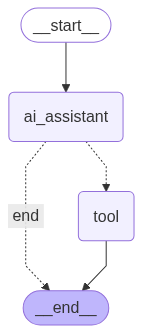

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
for s in app.stream({"messages": ["Why is the russia-ukrain war is happing?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AU0Vx2qGCU1OK7HSgILrepfZ', 'function': {'arguments': '{"query":"Reasons for the Russia-Ukraine war"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 83, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BefkiobrluJgmaDiqD5rgIbArYJEK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b49bd927-61fb-4a30-8941-65dbcbf1b7f1-0', tool_calls=[{'name': 'search', 'args': {'query': 'Reasons for the Russia-Ukraine war'}, 'id': 'call_AU0Vx2qGCU1OK7HSgILrepfZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 20, '

### LangGraph's interrupt_before functionality(human-in-the-loop)to always break the tool node.


In [29]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [30]:
tavily=TavilySearchResults()
tools = [tavily]
llm_with_tools = llm.bind_tools(tools)

In [31]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
     

In [32]:
memory = MemorySaver()

In [33]:
graph = StateGraph(AgentState)
graph.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.add_edge(START, "ai_assistant")

graph.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph.add_edge("tools", "ai_assistant")
     

In [34]:
app1 = graph.compile(
    checkpointer=memory,
    interrupt_before=["tools"], # Here interrupt_before= ['tools] means when it is cleared by ai_assistent that for this certain query we are going to use tools in that case before hitting the right tool (told by ai_assistent) our model required human intervention. until human will intervene the model will be stoped here only(not hit the that defined 'tool'). it will just wait for human intervantion indefinetely. we can also interrupt __after__ tools, if desired, interrupt_after=["tools"].
    )

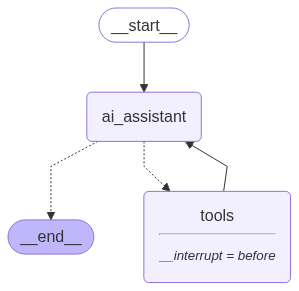

In [35]:
from IPython.display import Image, display
display(Image(app1.get_graph().draw_mermaid_png()))
     

In [36]:
user_input = "who is the current president of USA?"
config = {"configurable": {"thread_id": "001"}}

In [37]:
events = app1.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [38]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

who is the current president of USA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jvMUJZJ1kXGdWI6L5f8DZnAr)
 Call ID: call_jvMUJZJ1kXGdWI6L5f8DZnAr
  Args:
    query: current president of USA


#### Here from above output we can clearly see that for query "who is the current president of USA?" our ai_assistent required tool's help, but we already 'interrupt_before=["tools"]' defined which is stoping the process before hitting the concerned tool. 


In [39]:
snapshot = app1.get_state(config)

In [40]:
snapshot.next  # tell what is the next step for that this process required human intervention.

('tools',)

In [41]:
last_message=snapshot.values["messages"][-1]

In [42]:
last_message.tool_calls    # Tool details to which this is going to call 

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current president of USA'},
  'id': 'call_jvMUJZJ1kXGdWI6L5f8DZnAr',
  'type': 'tool_call'}]

#### So, because process/flow has stoped, to resume the flow we need to just pass the 'None' ,  by this it will resume the stoped process.

In [43]:
events = app1.stream(None, config, stream_mode="values")

In [44]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jvMUJZJ1kXGdWI6L5f8DZnAr)
 Call ID: call_jvMUJZJ1kXGdWI6L5f8DZnAr
  Args:
    query: current president of USA
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Presidents, vice presidents, and first ladies | USAGov", "url": "https://www.usa.gov/presidents", "content": "Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\n[The 47th and current president of the United States is Donald John Trump.](https://www.whitehouse.gov/administration/donald-j-trump/) He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] [The 50th and current vice president

In [45]:
snapshot= app1.get_state(config)

In [47]:
snapshot.next     # This is expty because there is no next step is remianed which is not executed yet.

()

#### appending human message through human-in-the-loop

In [48]:
user_input = "who is Israel's prime minister?"
config = {"configurable": {"thread_id": "001"}}

In [49]:
events = app1.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [50]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

who is Israel's prime minister?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mWRRKvd5K69XgCdQu2DrqMGT)
 Call ID: call_mWRRKvd5K69XgCdQu2DrqMGT
  Args:
    query: current Prime Minister of Israel


In [51]:
snapshot1= app1.get_state(config)

In [52]:
current_message= snapshot1.values['messages'][-1]

In [53]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mWRRKvd5K69XgCdQu2DrqMGT)
 Call ID: call_mWRRKvd5K69XgCdQu2DrqMGT
  Args:
    query: current Prime Minister of Israel


In [63]:
tool_call_id= current_message.tool_calls[0]['id']

In [64]:
tool_call_id

'call_mWRRKvd5K69XgCdQu2DrqMGT'

In [65]:
answer = "Current Pm of Israel is Benjamin Netanyahu"

In [66]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [67]:
app1.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '001',
  'checkpoint_ns': '',
  'checkpoint_id': '1f041317-87c7-6a04-8008-8fecb0707352'}}

In [68]:
print(app1.get_state(config).values["messages"][-1:])

[AIMessage(content='Current Pm of Israel is Benjamin Netanyahu', additional_kwargs={}, response_metadata={}, id='08da5485-3beb-4b50-ac4c-764101c18331')]
